In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
def u_true(x, t, a, b, c, gamma, pluck_position, height=0.05, n_terms=200):
    L = b - a
    k = gamma / 2

    # Handle scalar vs array inputs for x and t
    # If t is an array (history plot), u should match t's shape
    # If x is an array (snapshot plot), u should match x's shape
    if np.ndim(x) > 0 and np.ndim(t) == 0:
        u = np.zeros_like(x)
        mode_shape = lambda n: np.sin(n * np.pi * x / L)
        time_part = lambda n, wd, tt: np.cos(wd*tt) + (k/wd)*np.sin(wd*tt) if wd!=0 else 1.0
    elif np.ndim(t) > 0:
        u = np.zeros_like(t)
        mode_shape = lambda n: np.sin(n * np.pi * pluck_position / L) # Fixed x for time history
        time_part = lambda n, wd, tt: np.cos(wd*tt) + (k/wd)*np.sin(wd*tt) if wd!=0 else 1.0
    else:
        u = 0.0 # Scalar case

    for n in range(1, n_terms + 1):
        wn = n * np.pi * c / L
        if wn > k:
            wd = np.sqrt(wn**2 - k**2)
        else:
            wd = 0

        # Fourier coefficient a_n (Corrected with sin term)
        numerator = 2 * height * L**2 * np.sin((n*np.pi*pluck_position)/L)
        denominator = (n * np.pi)**2 * pluck_position * (L - pluck_position)
        a_n = numerator / denominator

        # Calculate term
        term_val = time_part(n, wd, t)

        # Combine
        if np.ndim(x) > 0 and np.ndim(t) == 0:
             u += np.exp(-k * t) * a_n * term_val * mode_shape(n)
        elif np.ndim(t) > 0:
             # For time history, x is fixed inside the loop logic or passed as scalar
             # We use the specific location passed in x argument (which is pluck_pos in this logic)
             # But to keep your function signature, we assume 'x' is the location for time history
             u += np.exp(-k * t) * a_n * term_val * np.sin(n * np.pi * x / L)

    return u

In [5]:
## Numerical Solver ##

def A_matrix(a, b, n_x, c):
    x = np.linspace(a, b, n_x+1)
    dx = x[1] - x[0]

    A = np.zeros((n_x-1, n_x-1))
    diag = -2 * c**2 / dx**2
    off = c**2 / dx**2

    np.fill_diagonal(A, diag)
    rows, cols = np.indices(A.shape)
    A[rows == cols - 1] = off
    A[rows == cols + 1] = off

    return A, dx

def guitar_string_solver(a, b, n_x, dt, T, gamma, c):
    n_t = int(T / dt)
    t_arr = np.linspace(0, n_t*dt, n_t+1)
    sound = np.zeros((n_t+1, n_x+1))

    pluck_idx = int(0.3 * n_x)
    A, dx = A_matrix(a, b, n_x, c)

    u = np.zeros(n_x+1)
    u[:pluck_idx] = np.linspace(0, 0.05, pluck_idx)
    u[pluck_idx:] = np.linspace(0.05, 0, n_x+1 - pluck_idx)

    sound[0] = u
    u_prev = u[1:-1].copy()

    accel = A @ u_prev
    u_curr = u_prev + 0.5 * dt**2 * accel
    sound[1,1:-1] = u_curr

    alpha = gamma * dt / 2

    for n in range(2, n_t+1):
        accel = A @ u_curr
        u_next = (dt**2 * accel + 2*u_curr - (1-alpha)*u_prev) / (1+alpha)
        sound[n,1:-1] = u_next
        u_prev, u_curr = u_curr, u_next

    return sound, t_arr, dx


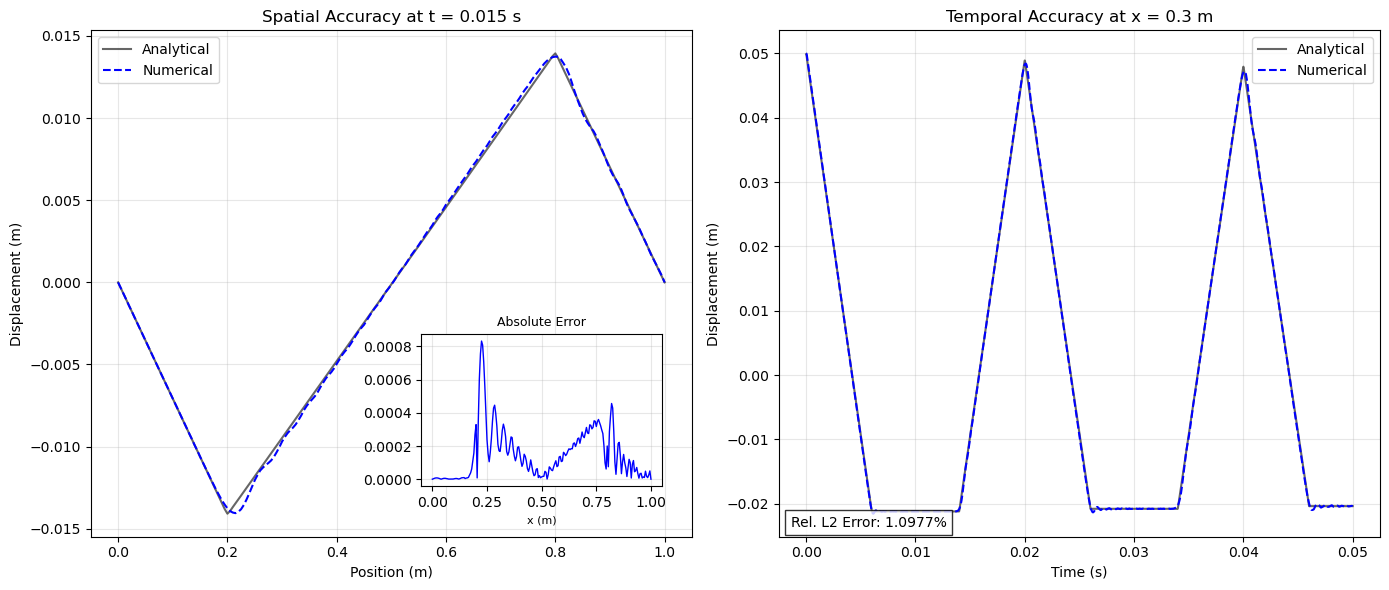

In [6]:
#Accuracy Analysis Execution##

# Physical parameters, can be changing per case

L = 1.0          # string length [m]
c = 100.0        # wave speed [m/s]
gamma = 2.0      # damping coefficient [1/s]
a = 0.0
b = L

# Numerical parameters
N = 200                  # spatial grid points
T_snapshot = 0.015       # time for spatial comparison [s]
T_total = 0.05           # total simulation time [s]

# Ensure numerical stability (CFL condition)
dx = L / N
dt = 0.1 * dx / c  # safety factor for CFL

# running the simulation
sound_matrix, t_vector, dx_calc = guitar_string_solver(a, b, N, dt, T_total, gamma, c)

# Extract spatial snapshot at T_snapshot
idx_snap = np.argmin(np.abs(t_vector - T_snapshot))
u_spatial_num = sound_matrix[idx_snap, :]
x_axis = np.linspace(a, b, N+1)
u_spatial_ana = u_true(x_axis, T_snapshot, a, b, c, gamma, pluck_position=0.3*L)

# Extract temporal history at pluck point
idx_probe = int(0.3 * N)
u_temporal_num = sound_matrix[:, idx_probe]
u_temporal_ana = u_true(0.3*L, t_vector, a, b, c, gamma, pluck_position=0.3*L)

# Create plots to compare numerical and analytical solutions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Spatial accuracy plot
ax[0].plot(x_axis, u_spatial_ana, 'k-', lw=1.5, alpha=0.6, label='Analytical')
ax[0].plot(x_axis, u_spatial_num, 'b--', lw=1.5, label='Numerical')
ax[0].set_title(f"Spatial Accuracy at t = {T_snapshot} s")
ax[0].set_xlabel("Position (m)")
ax[0].set_ylabel("Displacement (m)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Add error inset
ax_err = ax[0].inset_axes([0.55, 0.1, 0.4, 0.3])
error_spatial = np.abs(u_spatial_num - u_spatial_ana)
ax_err.plot(x_axis, error_spatial, 'b-', lw=1)
ax_err.set_title("Absolute Error", fontsize=9)
ax_err.set_xlabel("x (m)", fontsize=8)
ax_err.grid(True, alpha=0.3)

# Plot temporal accuracy
ax[1].plot(t_vector, u_temporal_ana, 'k-', lw=1.5, alpha=0.6, label='Analytical')
ax[1].plot(t_vector, u_temporal_num, 'b--', lw=1.5, label='Numerical')
ax[1].set_title(f"Temporal Accuracy at x = {0.3*L} m")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Displacement (m)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Show error metric
l2_error = np.linalg.norm(u_temporal_num - u_temporal_ana) / np.linalg.norm(u_temporal_ana)
ax[1].text(0.02, 0.02, f"Rel. L2 Error: {l2_error:.4%}",
           transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("spatial_temporal_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()



Simulation exploded at step 90/392 (t = 0.0092 s)


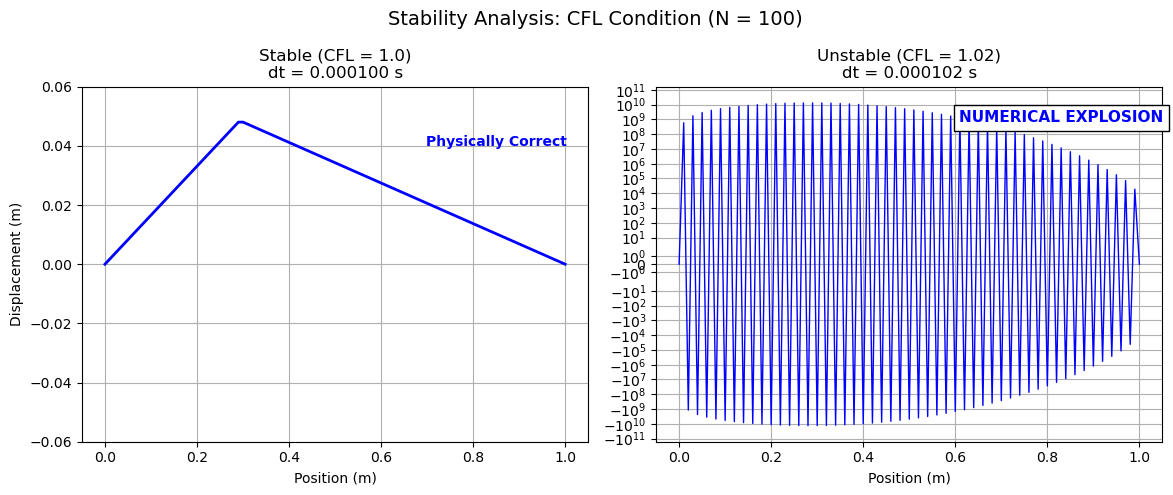

In [7]:
##Stability Analysis Execution##

def run_stability_test(N, CFL, T_final=0.04):

    # Physical parameters (use same as before for consistency)
    L = 1.0
    c = 100.0
    gamma = 2.0

    # Grid
    dx = L / N
    dt = CFL * dx / c

    x = np.linspace(0, L, N+1)
    n_t = int(T_final / dt)

    # Build spatial operator
    A = np.zeros((N-1, N-1))
    diag_val = -2 * c**2 / dx**2
    off_diag = c**2 / dx**2
    np.fill_diagonal(A, diag_val)
    rows, cols = np.indices((N-1, N-1))
    A[rows == cols - 1] = off_diag
    A[rows == cols + 1] = off_diag

    # Initial condition of the string
    u = np.zeros(N+1)
    pluck_idx = int(0.3 * N)
    height = 0.05
    u[0:pluck_idx] = np.linspace(0, height, pluck_idx)
    u[pluck_idx:] = np.linspace(height, 0, N+1 - pluck_idx)

    u_curr = u[1:-1].copy()
    u_prev = u_curr.copy()

    # Initializing with first step
    accel = A @ u_curr
    u_next = u_curr + 0.5 * dt**2 * accel

    u_prev = u_curr.copy()
    u_curr = u_next.copy()

    alpha = gamma * dt / 2

    # Time loop with explosion check
    for n in range(2, n_t+1):
        accel = A @ u_curr
        u_next = (dt**2 * accel + 2 * u_curr - (1 - alpha) * u_prev) / (1 + alpha)

        # Check for numerical error explosion
        if np.max(np.abs(u_next)) > 1e10:
            print(f"Simulation exploded at step {n}/{n_t} (t = {n*dt:.4f} s)")
            u_curr = u_next
            break

        # Update states
        u_prev = u_curr.copy()
        u_curr = u_next.copy()

    u_final = np.zeros(N+1)
    u_final[1:-1] = u_curr
    return x, u_final, dt


N = 100

# Stable case of CFL = 1.0
x_stab, u_stab, dt_stab = run_stability_test(N, CFL=1.0)

# Unstable case of CFL = 1.02
x_unst, u_unst, dt_unst = run_stability_test(N, CFL=1.02)

# Plot comparison of the two cases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Stable solution
ax1.plot(x_stab, u_stab, 'b-', linewidth=2)
ax1.set_title(f"Stable (CFL = 1.0)\ndt = {dt_stab:.6f} s")
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Displacement (m)")
ax1.set_ylim(-0.06, 0.06)
ax1.grid(True)
ax1.text(0.85, 0.04, "Physically Correct", ha='center',
         color='blue', fontweight='bold')

# Unstable solution
ax2.plot(x_unst, u_unst, 'b-', linewidth=1)
ax2.set_title(f"Unstable (CFL = 1.02)\ndt = {dt_unst:.6f} s")
ax2.set_xlabel("Position (m)")
ax2.set_yscale('symlog')  # log scale to show explosion
ax2.grid(True)
ax2.text(0.8, 0.9, "NUMERICAL EXPLOSION", transform=ax2.transAxes,
         ha='center', color='blue', fontsize=11, fontweight='bold',
         bbox=dict(facecolor='white'))

plt.suptitle(f"Stability Analysis: CFL Condition (N = {N})", fontsize=14)
plt.tight_layout()
plt.savefig("stability.png", dpi=300, bbox_inches="tight")
plt.show()


N          | Time (s)     | RMS Error   
----------------------------------------
50         | 0.00735      | 1.18541e-03 
100        | 0.01492      | 6.06024e-04 
200        | 0.03222      | 3.04817e-04 
400        | 0.06843      | 1.53197e-04 
800        | 0.17474      | 7.68506e-05 
1600       | 0.43851      | 3.82899e-05 


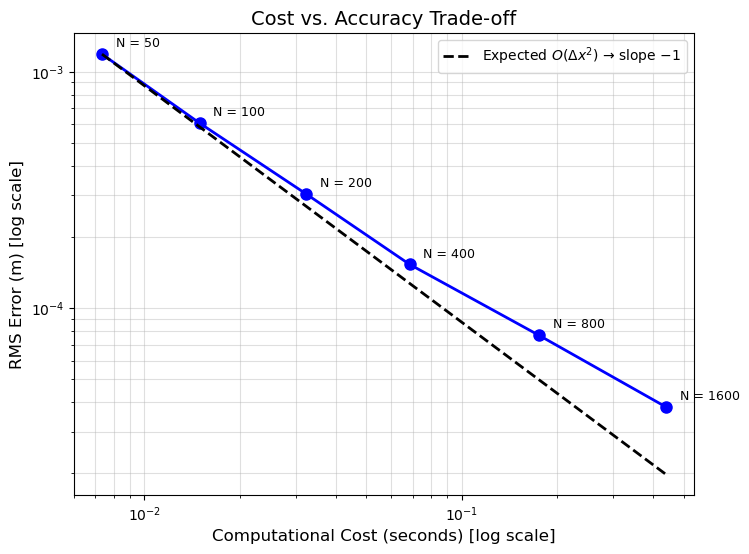

CFL        | dt (s)       | RMS Error   
----------------------------------------
0.05       | 2.500000e-06 | 3.21617e-04 
0.1        | 5.000000e-06 | 3.20794e-04 
0.2        | 1.000000e-05 | 3.18645e-04 
0.4        | 2.000000e-05 | 3.10756e-04 
0.8        | 4.000000e-05 | 2.76606e-04 


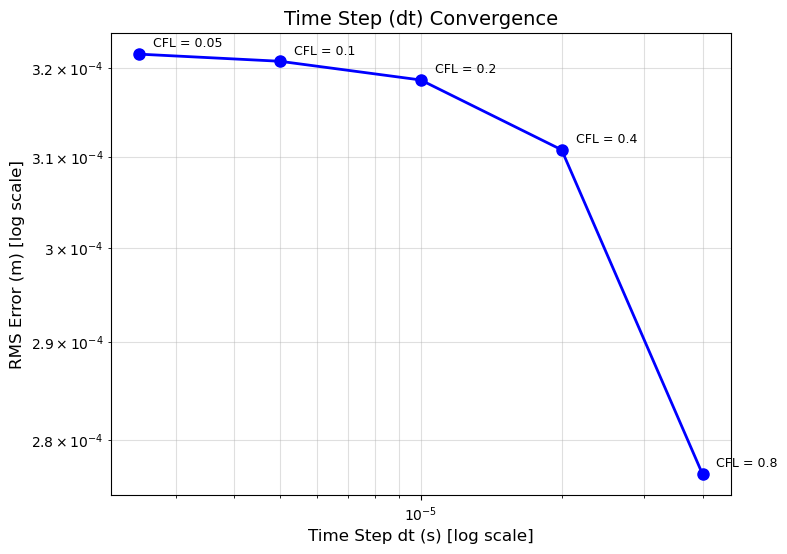

In [8]:


##Computational Cost Analysis Execution##

def run_simulation_timed(N, CFL=0.5, T_final=0.05, L=1.0, c=100.0, gamma=2.0):

    #run simulation and time it for cost analysis: mirrors previous solver

    dx = L / N
    dt = CFL * dx / c
    x = np.linspace(0, L, N+1)
    n_t = int(T_final / dt)

    alpha = gamma * dt / 2
    r_sq = (c * dt / dx)**2

    # Initial condition of the string
    u = np.zeros(N+1)
    pluck_idx = int(0.3 * N)
    u[0:pluck_idx] = np.linspace(0, 0.05, pluck_idx)
    u[pluck_idx:] = np.linspace(0.05, 0, N+1 - pluck_idx)

    u_curr = u.copy()
    u_prev = u.copy()

    # Start timer
    start_time = time.perf_counter()

    # initial step
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u_curr[2:] - 2*u_curr[1:-1] + u_curr[:-2]) / dx**2
    u_next = u_curr + 0.5 * dt**2 * (c**2 * u_xx)
    u_prev, u_curr = u_curr.copy(), u_next.copy()

    # Main time loop
    for n in range(2, n_t+1):
        u_xx[1:-1] = (u_curr[2:] - 2*u_curr[1:-1] + u_curr[:-2]) / dx**2
        accel = c**2 * u_xx
        u_next = (dt**2 * accel + 2 * u_curr - (1 - alpha) * u_prev) / (1 + alpha)
        u_prev, u_curr = u_curr.copy(), u_next.copy()

    end_time = time.perf_counter()
    return x, u_curr, (end_time - start_time)


def get_analytical_final(x, t, L=1.0, c=100.0, gamma=2.0, p=0.3, h=0.05, n_terms=200):

    #calculate analytical solution at time t for error calculation

    k = gamma / 2
    u = np.zeros_like(x)
    for n in range(1, n_terms + 1):
        wn = n * np.pi * c / L
        wd = np.sqrt(wn**2 - k**2) if wn > k else 0
        a_n = (2*h*L**2 / ((n*np.pi)**2 * p*(L-p))) * np.sin(n*np.pi*p/L)

        time_term = np.cos(wd*t) + (k/wd)*np.sin(wd*t) if wd != 0 else 1.0
        u += np.exp(-k * t) * a_n * time_term * np.sin(n * np.pi * x / L)
    return u

#set N values and initialize lists
N_values = [50, 100, 200, 400, 800, 1600]
costs = []
errors = []

print(f"{'N':<10} | {'Time (s)':<12} | {'RMS Error':<12}")
print("-" * 40)

for val in N_values:
    # Run numerical simulation
    x_num, u_num, runtime = run_simulation_timed(N=val)

    # Get analytical solution for comparison
    u_ana = get_analytical_final(x_num, 0.05)

    # Calculate error
    rms_error = np.sqrt(np.mean((u_num - u_ana)**2))

    costs.append(runtime)
    errors.append(rms_error)
    print(f"{val:<10} | {runtime:<12.5f} | {rms_error:<12.5e}")

# Plot cost vs accuracy trade-off
plt.figure(figsize=(8, 6))
plt.loglog(costs, errors, 'bo-', linewidth=2, markersize=8)

# Annotate points
for i, txt in enumerate(N_values):
    plt.annotate(f"N = {txt}", (costs[i], errors[i]),
                 xytext=(10, 5), textcoords='offset points', fontsize=9)

# ----- Expected convergence rate (2nd order in space) -----
ref_cost = np.array(costs)
ref_error = errors[0] * (ref_cost / ref_cost[0])**(-1)

plt.loglog(ref_cost, ref_error, 'k--', linewidth=2,
           label=r"Expected $O(\Delta x^2)$ → slope $-1$")

plt.legend()


plt.title("Cost vs. Accuracy Trade-off", fontsize=14)
plt.xlabel("Computational Cost (seconds) [log scale]", fontsize=12)
plt.ylabel("RMS Error (m) [log scale]", fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.savefig("cost_plot.png", dpi=300, bbox_inches="tight")
plt.show()

## Time Step Convergence Analysis (dt) ##

# Fix spatial resolution
N = 200
L = 1.0
c = 100.0
gamma = 2.0
T_final = 0.05

# CFL values to test (controls dt)
CFL_values = [0.05, 0.1, 0.2, 0.4, 0.8, ]

#initialize lists
dt_values = []
dt_errors = []

print(f"{'CFL':<10} | {'dt (s)':<12} | {'RMS Error':<12}")
print("-" * 40)

for CFL in CFL_values:
    dx = L / N #from fixed N
    dt = CFL * dx / c #calculate dt from CFL

    # Run numerical simulation
    x_num, u_num, runtime = run_simulation_timed(
        N=N, CFL=CFL, T_final=T_final
    )

    # Analytical solution
    u_ana = get_analytical_final(x_num, T_final)

    # collect error
    rms_error = np.sqrt(np.mean((u_num - u_ana)**2))

    dt_values.append(dt)
    dt_errors.append(rms_error)

    print(f"{CFL:<10} | {dt:<12.6e} | {rms_error:<12.5e}")

plt.figure(figsize=(8, 6))
plt.loglog(dt_values, dt_errors, 'bo-', linewidth=2, markersize=8)


# Annotate points
for i, CFL in enumerate(CFL_values):
    plt.annotate(f"CFL = {CFL}", (dt_values[i], dt_errors[i]),
                 xytext=(10, 5), textcoords='offset points', fontsize=9)

plt.title("Time Step (dt) Convergence", fontsize=14)
plt.xlabel("Time Step dt (s) [log scale]", fontsize=12)
plt.ylabel("RMS Error (m) [log scale]", fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.savefig("dt_convergence.png", dpi=300, bbox_inches="tight")

plt.show()


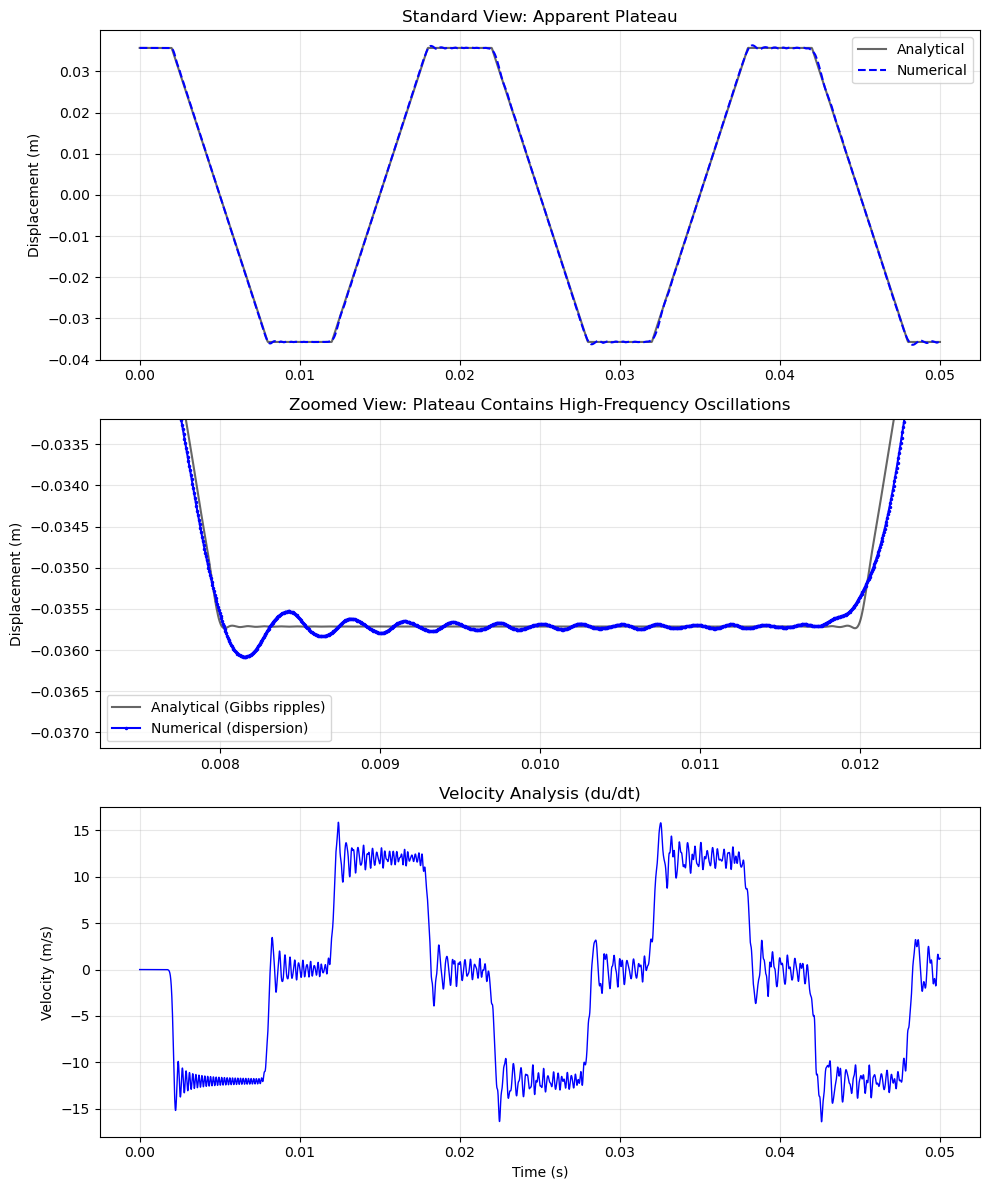

In [9]:
##Plateau Analysis Execution (gibbs phenomenom)##

def u_true_time_history(x_loc, t_arr, L, c, gamma, pluck_pos, height=0.05, n_terms=200):

    #analytical solution for time history at a point

    k = gamma / 2
    u = np.zeros_like(t_arr)
    for n in range(1, n_terms + 1):
        wn = n * np.pi * c / L
        wd = np.sqrt(wn**2 - k**2) if wn > k else 0

        numerator = 2 * height * L**2
        denominator = (n * np.pi)**2 * pluck_pos * (L - pluck_pos)
        shape_factor = np.sin(n * np.pi * pluck_pos / L)
        a_n = (numerator / denominator) * shape_factor

        time_term = np.cos(wd * t_arr) + (k / wd) * np.sin(wd * t_arr) if wd != 0 else 1.0
        u += np.exp(-k * t_arr) * a_n * time_term * np.sin(n * np.pi * x_loc / L)
    return u



# Simulations with no damping to highlight plateau effect
L = 1.0
c = 100.0
gamma = 0  # no damping present
T = 0.05
N = 200
dx = L/N
dt = 0.1 * dx / c

sound_matrix, t_num, dx_returned = guitar_string_solver(0, L, N, dt, T, gamma, c)

# Probe at midpoint
probe_idx = int(0.5 * N)
u_num_series = sound_matrix[:, probe_idx]
u_ana_series = u_true_time_history(probe_idx*dx, t_num, L, c, gamma, 0.3*L, n_terms=200)

# velocity calculation to reveal hidden oscillations
v_num_series = np.gradient(u_num_series, dt)

# plot to show those hidden oscillations
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Standard view
ax[0].plot(t_num, u_ana_series, 'k-', alpha=0.6, label='Analytical')
ax[0].plot(t_num, u_num_series, 'b--', label='Numerical')
ax[0].set_title("Standard View: Apparent Plateau")
ax[0].set_ylabel("Displacement (m)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Zoomed view reveals oscillations
t_start, t_end = 0.0075, 0.0125
mask = (t_num >= t_start) & (t_num <= t_end)

ax[1].plot(t_num[mask], u_ana_series[mask], 'k-', alpha=0.6,
           label='Analytical (Gibbs ripples)')
ax[1].plot(t_num[mask], u_num_series[mask], 'b.-', markersize=3,
           label='Numerical (dispersion)')
ax[1].set_title("Zoomed View: Plateau Contains High-Frequency Oscillations")
ax[1].set_ylabel("Displacement (m)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# noise shown with tight y-limits
y_center = np.mean(u_num_series[mask])
ax[1].set_ylim(y_center - 0.002, y_center + 0.002)

# proving oscillations with velocity plot
ax[2].plot(t_num, v_num_series, 'b-', lw=1)
ax[2].set_title("Velocity Analysis (du/dt)")
ax[2].set_ylabel("Velocity (m/s)")
ax[2].set_xlabel("Time (s)")
# ax[2].text(0.02, 0, "Velocity spikes confirm\nactive oscillation",
        #    bbox=dict(facecolor='white', alpha=0.8))
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plateau_plot.png", dpi=300, bbox_inches="tight")
plt.show()


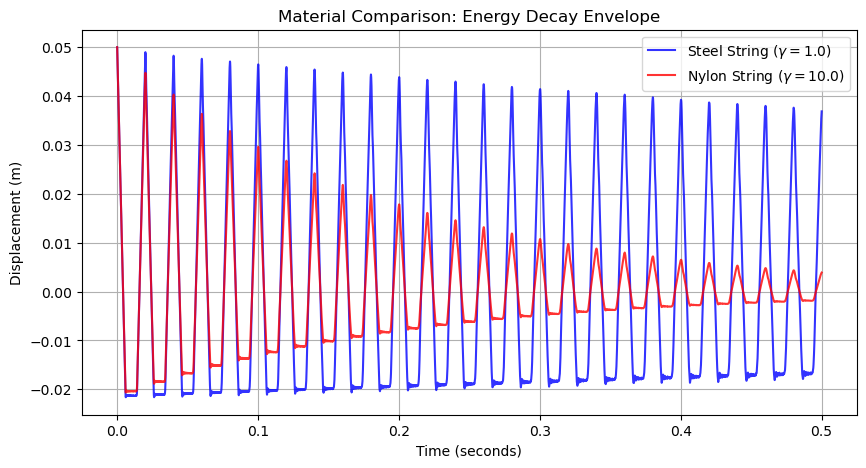

In [10]:
L = 1.0; c = 100.0; N = 200
T = 0.5 # 0.5 seconds duration
dx = L/N
dt = 0.5 * dx / c

sound_steel, _, _ = guitar_string_solver(0, L, N, dt, T, gamma=1.0, c=c) # damping constant for steel

# Case B: Nylon (Gamma = 10.0)
sound_nylon, _, _ = guitar_string_solver(0, L, N, dt, T, gamma=10.0, c=c) # damping constant for nylon

t = np.linspace(0, T, int(T/dt)+1)

monitor_idx = int(0.3 * N)

plt.figure(figsize=(10, 5))
plt.title("Material Comparison: Energy Decay Envelope")

plt.plot(t, sound_steel[:, monitor_idx], 'b-', label='Steel String ($\gamma=1.0$)', alpha=0.8)
plt.plot(t, sound_nylon[:, monitor_idx], 'r-', label='Nylon String ($\gamma=10.0$)', alpha=0.8)

plt.xlabel("Time (seconds)")
plt.ylabel("Displacement (m)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

NameError: name 'files' is not defined

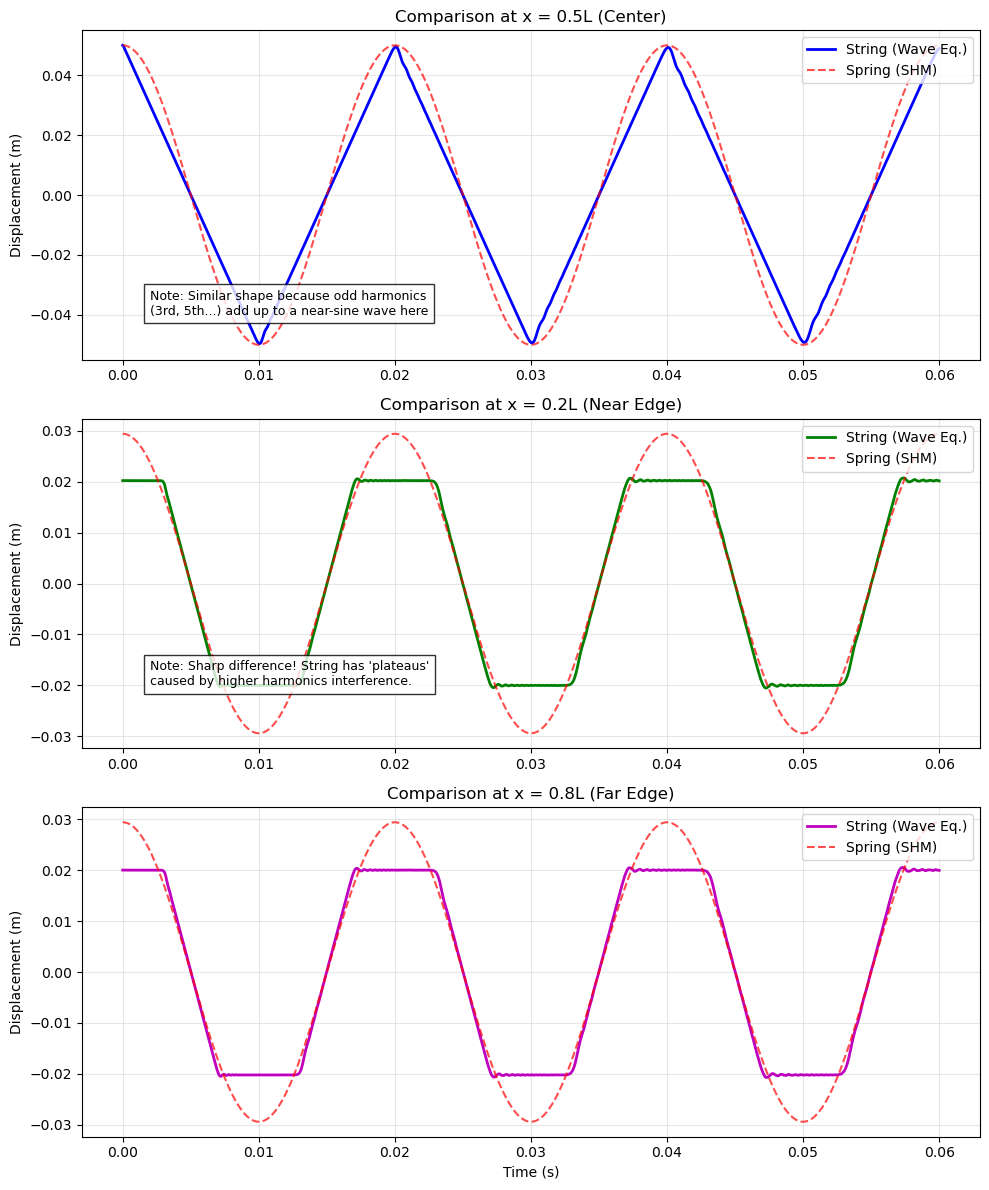

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def run_spring_vs_string_comparison():
    # --- 1. Parameters ---
    L = 1.0
    c = 100.0
    gamma = 0.0     # Undamped for fair comparison
    T_total = 0.06  # 3 periods
    N = 200

    # Grid Setup
    dx = L / N
    dt = 0.5 * dx / c
    n_t = int(T_total / dt)
    t_arr = np.linspace(0, T_total, n_t+1)

    # --- 2. String Solver (Wave Equation) ---
    u = np.zeros(N+1)
    pluck_idx = int(0.5 * N) # Pluck at CENTER
    height = 0.05
    u[0:pluck_idx] = np.linspace(0, height, pluck_idx)
    u[pluck_idx:]  = np.linspace(height, 0, N+1 - pluck_idx)

    u_curr = u.copy()
    u_prev = u.copy()

    # Probe Indices
    idx_1 = int(0.2 * N)
    idx_2 = int(0.5 * N)
    idx_3 = int(0.8 * N)

    hist_string_1 = np.zeros(n_t+1)
    hist_string_2 = np.zeros(n_t+1)
    hist_string_3 = np.zeros(n_t+1)

    # Precompute loop constants
    r2 = (c * dt / dx)**2

    # First Step
    u_next = np.zeros_like(u)
    for i in range(1, N):
        u_next[i] = u_curr[i] + 0.5 * r2 * (u_curr[i+1] - 2*u_curr[i] + u_curr[i-1])

    hist_string_1[0] = u_curr[idx_1]; hist_string_1[1] = u_next[idx_1]
    hist_string_2[0] = u_curr[idx_2]; hist_string_2[1] = u_next[idx_2]
    hist_string_3[0] = u_curr[idx_3]; hist_string_3[1] = u_next[idx_3]

    u_prev = u_curr.copy()
    u_curr = u_next.copy()

    # Main Loop
    for n in range(2, n_t+1):
        for i in range(1, N):
            u_next[i] = r2*(u_curr[i+1] - 2*u_curr[i] + u_curr[i-1]) + 2*u_curr[i] - u_prev[i]

        hist_string_1[n] = u_next[idx_1]
        hist_string_2[n] = u_next[idx_2]
        hist_string_3[n] = u_next[idx_3]

        u_prev = u_curr.copy()
        u_curr = u_next.copy()

    # --- 3. Spring Solver (Simple Harmonic Motion) ---
    # Frequency f = c / 2L = 100 / 2 = 50 Hz
    omega = 2 * np.pi * 50

    # We calculate the "Spring" equivalent for each location
    # The amplitude of the fundamental mode at position x is A * sin(pi*x/L)
    # This represents what the motion WOULD be if higher harmonics didn't exist
    amp_1 = height * np.sin(np.pi * (0.2*L) / L) # Theoretical amp at 0.2L
    amp_2 = height * np.sin(np.pi * (0.5*L) / L) # Theoretical amp at 0.5L
    amp_3 = height * np.sin(np.pi * (0.8*L) / L) # Theoretical amp at 0.8L

    spring_1 = amp_1 * np.cos(omega * t_arr)
    spring_2 = amp_2 * np.cos(omega * t_arr)
    spring_3 = amp_3 * np.cos(omega * t_arr)

    # --- 4. Plotting ---
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot 1: Center (0.5L)
    axs[0].plot(t_arr, hist_string_2, 'b-', lw=2, label='String (Wave Eq.)')
    axs[0].plot(t_arr, spring_2, 'r--', lw=1.5, alpha=0.7, label='Spring (SHM)')
    axs[0].set_title(f"Comparison at x = 0.5L (Center)")
    axs[0].set_ylabel("Displacement (m)")
    axs[0].legend(loc='upper right')
    axs[0].grid(True, alpha=0.3)
    axs[0].text(0.002, -0.04, "Note: Similar shape because odd harmonics\n(3rd, 5th...) add up to a near-sine wave here", fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

    # Plot 2: Near Edge (0.2L)
    axs[1].plot(t_arr, hist_string_1, 'g-', lw=2, label='String (Wave Eq.)')
    axs[1].plot(t_arr, spring_1, 'r--', lw=1.5, alpha=0.7, label='Spring (SHM)')
    axs[1].set_title(f"Comparison at x = 0.2L (Near Edge)")
    axs[1].set_ylabel("Displacement (m)")
    axs[1].legend(loc='upper right')
    axs[1].grid(True, alpha=0.3)
    axs[1].text(0.002, -0.02, "Note: Sharp difference! String has 'plateaus'\ncaused by higher harmonics interference.", fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

    # Plot 3: Far Edge (0.8L)
    axs[2].plot(t_arr, hist_string_3, 'm-', lw=2, label='String (Wave Eq.)')
    axs[2].plot(t_arr, spring_3, 'r--', lw=1.5, alpha=0.7, label='Spring (SHM)')
    axs[2].set_title(f"Comparison at x = 0.8L (Far Edge)")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Displacement (m)")
    axs[2].legend(loc='upper right')
    axs[2].grid(True, alpha=0.3)

    plt.tight_layout()
    filename = 'springstring_analysis.png'
    plt.savefig(filename, dpi=300)
    files.download(filename)
    plt.show()

run_spring_vs_string_comparison()

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def run_case_1():
    # Parameters for Case 1 (Undamped)
    L = 1.0
    c = 100.0
    gamma = 0.0     # NO DAMPING
    T_total = 0.06  # Show 3 full periods (Period = 2L/c = 0.02s)
    N = 200         # Grid size

    # Stability
    dx = L / N
    dt = 0.5 * dx / c # Safe CFL = 0.5
    n_t = int(T_total / dt)
    t_arr = np.linspace(0, T_total, n_t+1)

    # Solver Setup
    u = np.zeros(N+1)
    pluck_idx = int(0.5 * N) # Pluck at CENTER for Case 1 to see symmetry
    height = 0.05
    u[0:pluck_idx] = np.linspace(0, height, pluck_idx)
    u[pluck_idx:]  = np.linspace(height, 0, N+1 - pluck_idx)

    u_curr = u.copy()
    u_prev = u.copy()

    # Storage for 3 distinct probe locations
    idx_1 = int(0.2 * N) # Near edge
    idx_2 = int(0.5 * N) # Center
    idx_3 = int(0.8 * N) # Far edge

    hist_1 = np.zeros(n_t+1)
    hist_2 = np.zeros(n_t+1)
    hist_3 = np.zeros(n_t+1)

    # Precompute Loop Constants
    r2 = (c * dt / dx)**2

    # First Step
    u_next = np.zeros_like(u)
    for i in range(1, N):
        u_next[i] = u_curr[i] + 0.5 * r2 * (u_curr[i+1] - 2*u_curr[i] + u_curr[i-1])

    hist_1[0] = u_curr[idx_1]; hist_1[1] = u_next[idx_1]
    hist_2[0] = u_curr[idx_2]; hist_2[1] = u_next[idx_2]
    hist_3[0] = u_curr[idx_3]; hist_3[1] = u_next[idx_3]

    u_prev = u_curr.copy()
    u_curr = u_next.copy()

    # Time Loop (No damping terms needed since gamma=0)
    for n in range(2, n_t+1):
        for i in range(1, N):
            u_next[i] = r2*(u_curr[i+1] - 2*u_curr[i] + u_curr[i-1]) + 2*u_curr[i] - u_prev[i]

        hist_1[n] = u_next[idx_1]
        hist_2[n] = u_next[idx_2]
        hist_3[n] = u_next[idx_3]

        u_prev = u_curr.copy()
        u_curr = u_next.copy()

    # Plotting
    plt.figure(figsize=(10, 8))

    # Subplot 1: Center (0.5L)
    plt.subplot(3, 1, 1)
    plt.plot(t_arr, hist_2, 'b-', lw=1.5)
    plt.title("Position x = 0.5L (Center) - Symmetric Oscillation")
    plt.ylabel("Disp. (m)")
    plt.grid(True, alpha=0.3)

    # Subplot 2: Near Edge (0.2L)
    plt.subplot(3, 1, 2)
    plt.plot(t_arr, hist_1, 'g-', lw=1.5)
    plt.title("Position x = 0.2L (Near Edge) - Complex Interference")
    plt.ylabel("Disp. (m)")
    plt.grid(True, alpha=0.3)

    # Subplot 3: Far Edge (0.8L)
    plt.subplot(3, 1, 3)
    plt.plot(t_arr, hist_3, 'r-', lw=1.5)
    plt.title("Position x = 0.8L (Far Edge) - Symmetric to 0.2L")
    plt.xlabel("Time (s)")
    plt.ylabel("Disp. (m)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    filename4 = "case1_plot.png"
    plt.savefig(filename4, dpi=300, bbox_inches="tight")  # save BEFORE show
    plt.show()

run_case_1()

Running Study 1: Convergence in Time (Fixed dx)...


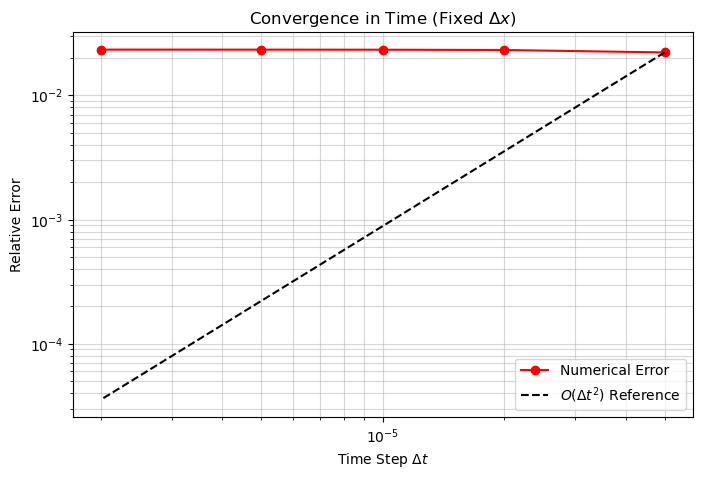

Running Spatial Convergence Study...


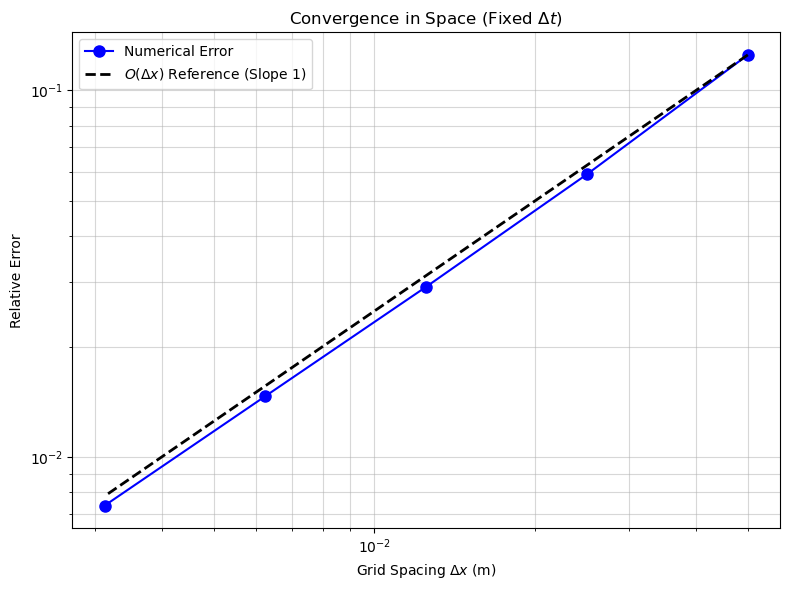

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
L = 1.0; c = 100.0; gamma = 2.0; T = 0.05
a = 0.0; b = L

# STUDY 1: Convergence in TIME (Error vs dt)
print("Running Study 1: Convergence in Time (Fixed dx)...")

# 1. Fix Space
N_fixed = 100
dx_fixed = (b - a) / N_fixed

dt_values = [5e-5, 2e-5, 1e-5, 5e-6, 2e-6]
errors_dt = []

for dt in dt_values:
    # using numerical solution
    sound, _, _ = guitar_string_solver(a, b, N_fixed, dt, T, gamma, c)
    u_num = sound[-1, :]

    # getting analytical solution
    x = np.linspace(a, b, N_fixed+1)
    u_exact = u_true(x, T, a, b, c, gamma, pluck_position=0.3*L)

    # Compute Error
    diff = u_num[1:-1] - u_exact[1:-1]
    err = np.linalg.norm(diff) / np.linalg.norm(u_exact[1:-1])
    errors_dt.append(err)

# PLOT (Error vs dt)
plt.figure(figsize=(8, 5))
plt.loglog(dt_values, errors_dt, 'ro-', label='Numerical Error')

# Reference Line dt^2
ref_line_dt = [errors_dt[0] * (d / dt_values[0])**2 for d in dt_values]
plt.loglog(dt_values, ref_line_dt, 'k--', label=r'$O(\Delta t^2)$ Reference')

plt.xlabel(r'Time Step $\Delta t$')
plt.ylabel('Relative Error')
plt.title(r'Convergence in Time (Fixed $\Delta x$)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig('convergence_dt.png')
plt.show()


# STUDY 2: CONVERGENCE IN SPACE
print("Running Spatial Convergence Study...")

# time is fixed
dt_fixed = 1e-6

# varying N values
N_values = [20, 40, 80, 160, 320]
dx_values = []
errors_dx = []

for N in N_values:
    dx = (b - a) / N
    dx_values.append(dx)

    # using numerical solver
    sound, _, _ = guitar_string_solver(a, b, N, dt_fixed, T, gamma, c)
    u_num = sound[-1, :]

    # getting Analytical solution
    x = np.linspace(a, b, N+1)
    u_exact = u_true(x, T, a, b, c, gamma, pluck_position=0.3*L)

    # Calculate Relative Error
    diff = u_num[1:-1] - u_exact[1:-1]
    err = np.linalg.norm(diff) / np.linalg.norm(u_exact[1:-1])
    errors_dx.append(err)

# PLOTTING
plt.figure(figsize=(8, 6))
plt.loglog(dx_values, errors_dx, 'bo-', label='Numerical Error', markersize=8)

# Reference Line: Slope 1 (Correct for Triangle Waves)
ref_line = [errors_dx[0] * (d / dx_values[0])**1 for d in dx_values]
plt.loglog(dx_values, ref_line, 'k--', label=r'$O(\Delta x)$ Reference (Slope 1)', linewidth=2)

plt.xlabel(r'Grid Spacing $\Delta x$ (m)')
plt.ylabel('Relative Error')
plt.title(r'Convergence in Space (Fixed $\Delta t$)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()